In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import numpy as np
import pandas as pd
import seaborn as sns

We load a dataset from [voteview.com](https://voteview.com), which tabulates the roll-call vote of every session of the U.S. Congress. Here, we load all of the votes cast by senators between the 91st and 111th sessions of Congress. 

In [2]:
senate = pd.read_csv("senate_votes.csv")
senate

,congress,rollnumber,icpsr,cast_code
0,91,1,52,1
1,91,1,142,6
2,91,1,165,6
3,91,1,645,6
4,91,1,688,6
...,...,...,...,...
1703219,111,696,49901,1
1703220,111,696,49903,1
1703221,111,696,94659,1
1703222,111,696,94910,1


The `rollnumber` is a serial number of the bill or resolution that was voted on, and `icpsr` is a unique identifier for everyone who has ever served in Congress.

Without going into parliamentary details, there are three codes that mean a "yes" vote and three that mean "no." We will encode these as +1 and -1, respectively, and record anything else as a 0.

In [3]:
def vote_type(v):
    if v in [1,2,3]: return 1
    elif v in [4,5,6]: return -1
    else: return 0

senate["vote"] = senate["cast_code"].apply(vote_type)
senate.head(6)

,congress,rollnumber,icpsr,cast_code,vote
0,91,1,52,1,1
1,91,1,142,6,-1
2,91,1,165,6,-1
3,91,1,645,6,-1
4,91,1,688,6,-1
5,91,1,823,1,1


In addition to the voting records, we will also access to the party affiliations of the individual senators. This information is loaded from a separate file here.

In [4]:
members = pd.read_csv("HSall_members.csv").set_index("icpsr")
members.tail(6)

,congress,chamber,state_icpsr,district_code,state_abbrev,party_code,occupancy,last_means,bioname,bioguide_id,...,died,nominate_dim1,nominate_dim2,nominate_log_likelihood,nominate_geo_mean_probability,nominate_number_of_votes,nominate_number_of_errors,conditional,nokken_poole_dim1,nokken_poole_dim2
icpsr,,,,,,,,,,,,,,,,,,,,,
20146,117,Senate,56,0.0,WV,200,NaN,NaN,"CAPITO, Shelley Moore",C001047,...,NaN,0.270,0.083,-86.76665,0.83526,482.0,29.0,NaN,0.310,0.160
40915,117,Senate,56,0.0,WV,100,NaN,NaN,"MANCHIN, Joe, III",M001183,...,NaN,-0.058,0.429,-46.55210,0.90848,485.0,12.0,NaN,-0.071,0.389
29940,117,Senate,25,0.0,WI,100,NaN,NaN,"BALDWIN, Tammy",B001230,...,NaN,-0.492,-0.138,-10.25820,0.97997,507.0,5.0,NaN,-0.412,-0.186
41111,117,Senate,25,0.0,WI,200,NaN,NaN,"JOHNSON, Ron",J000293,...,NaN,0.603,-0.237,-83.54680,0.83359,459.0,39.0,NaN,0.568,-0.055
20953,117,Senate,68,0.0,WY,200,NaN,NaN,"LUMMIS, Cynthia M.",L000571,...,NaN,0.680,-0.378,-73.86709,0.85370,467.0,27.0,NaN,0.683,-0.287
40707,117,Senate,68,0.0,WY,200,NaN,NaN,"BARRASSO, John A.",B001261,...,NaN,0.538,0.231,-74.38305,0.85477,474.0,26.0,NaN,0.536,0.170


There have been over 50 political parties for senators over U.S. history, as encoded by `party_code` above. For modern times, we want to identify the two major parties and label all the others as independent.

In [5]:
# First, set all possible codes to "Ind"
party_name = pd.Series("Ind",index=members["party_code"].unique()) 
# Now set the two we really care about
party_name[100] = "Dem"
party_name[200] = "Rep"

members["party"] = members["party_code"].replace(party_name)

print(members["party"].value_counts())

party
Dem    23147
Rep    19596
Ind     7192
Name: count, dtype: int64


We now write a function that returns the data we need to get the voting data within a single session. The first output is a table having the senator ID as the index, the individual roll calls as the columns, and values that are the individual votes. Any senator with a `NaN` in the record did not serve the full session, and their row is dropped. (Details: This requires a fancy [reshaping operation](https://pandas.pydata.org/docs/user_guide/reshaping.html) called a `pivot`.)

The second output is the list of party affiliations for the senators in the table. This list implies an obvious reference clustering by political party.

In [6]:
def session(number, senate, members):
    idx = senate["congress"] == number
    votes = senate.loc[idx].pivot(index="icpsr",columns="rollnumber",values="vote").dropna()
    idx = members["congress"] == number
    party = members.loc[idx,"party"][votes.index]
    # If more than one party affiliation, use only the last one:
    party = party.loc[np.bitwise_not(party.index.duplicated(keep="last"))]   
    return votes, party


The two ouputs from `session` are effectively the feature matrix and the party labels for the indicated session. So, for example, in the 100th Congress we have

In [7]:
X100, y100 = session(100, senate, members)
print("party counts:")
print(y100.value_counts())
print("\nfeature matrix:")
X100

party counts:
party
Dem    54
Rep    46
Name: count, dtype: int64

feature matrix:


rollnumber,1,2,3,4,5,6,7,8,9,10,...,790,791,792,793,794,795,796,797,798,799
icpsr,,,,,,,,,,,,,,,,,,,,,
660,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1252,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,...,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
1366,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
4812,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,...,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0
7638,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,...,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15501,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
15502,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,...,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,0.0
15503,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0


It's interesting to view this feature matrix as a heat map.

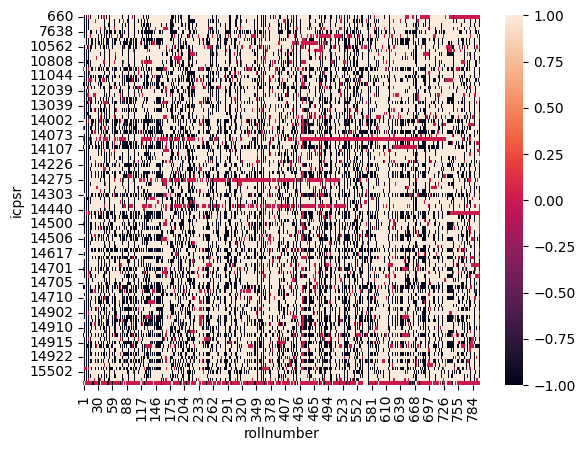

In [8]:
sns.heatmap(X100);

Each row is the voting record of a senator. Remember that the only values possible are $-1$, $0$, and $1$. You can definitely see some dominant motifs in the rows that imply party discipline. For the rest of the lab, you will investigate the extent of polarization in the Senate over time.

# 1 (6.1)
For the 95th Congress, compute the distance matrix using the cosine metric. Make a histogram showing the distribution of all the distances. (Hint: use `D.flatten()` to transform the distance matrix `D` into a vector for the histogram.)

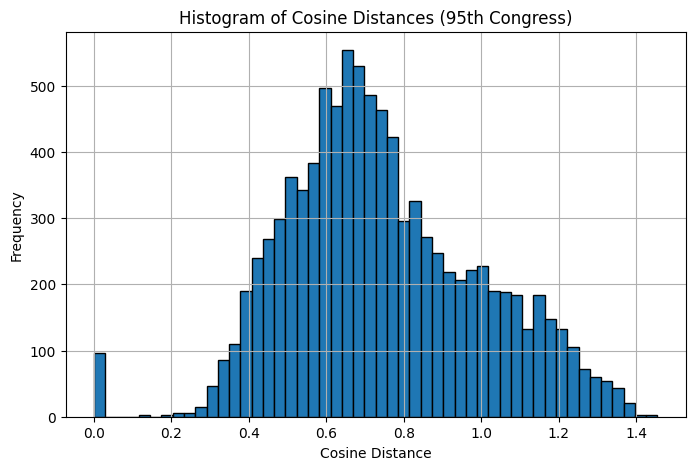

In [ ]:
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt

X95, y95 = session(95, senate, members)

D = cosine_distances(X95)

plt.figure(figsize=(8, 5))
plt.hist(D.flatten(), bins=50, edgecolor='black')
plt.title("Histogram of Cosine Distances (95th Congress)")
plt.xlabel("Cosine Distance")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


(Your histogram should have a single peak at a distance value around 0.7. There are also 100 instances of distance zero that come from the diagonal of the matrix.)

# 2 (6.1)
Repeat step 1 for the 110th session of Congress.

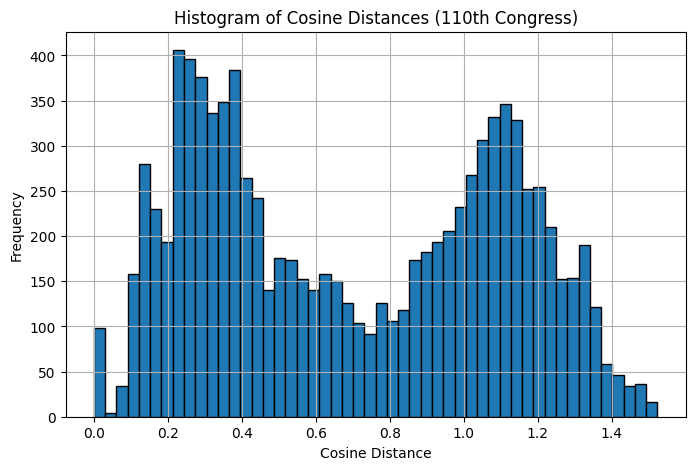

In [ ]:
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt

X110, y110 = session(110, senate, members)

D = cosine_distances(X110)

plt.figure(figsize=(8, 5))
plt.hist(D.flatten(), bins=50, edgecolor='black')
plt.title("Histogram of Cosine Distances (110th Congress)")
plt.xlabel("Cosine Distance")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


(You should see two distinct peaks in this distribution, which is suggestive of increased polarization.)

# 3 (6.2)
Party affiliations effectively define a reference clustering for each session. 

For the 95th Congress, make a box plot showing the distribution of silhouette values for each cluster as defined by party affiliation. (You want one box per party, even though there is only one *Ind* senator.)

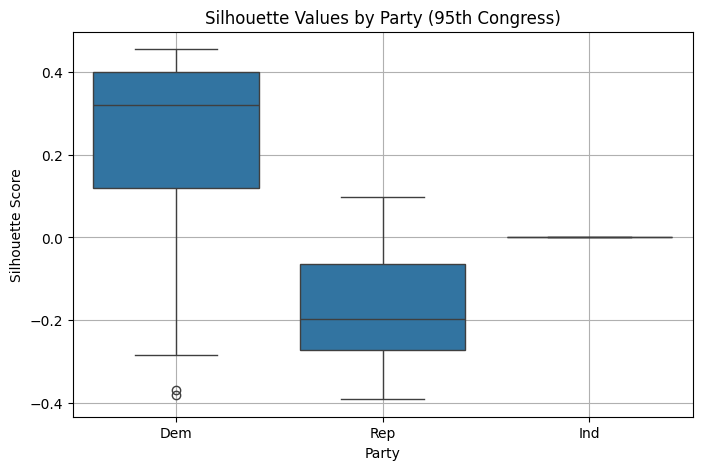

In [11]:
from sklearn.metrics import silhouette_samples
import seaborn as sns
import matplotlib.pyplot as plt

X95, y95 = session(95, senate, members)

D = cosine_distances(X95)

silhouette_vals = silhouette_samples(D, y95, metric='precomputed')

silhouette_df = pd.DataFrame({
    'Silhouette': silhouette_vals,
    'Party': y95.values
})

plt.figure(figsize=(8, 5))
sns.boxplot(data=silhouette_df, x='Party', y='Silhouette')
plt.title("Silhouette Values by Party (95th Congress)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


# 4 (6.2)
Repeat step 3 for the 110th Congress.

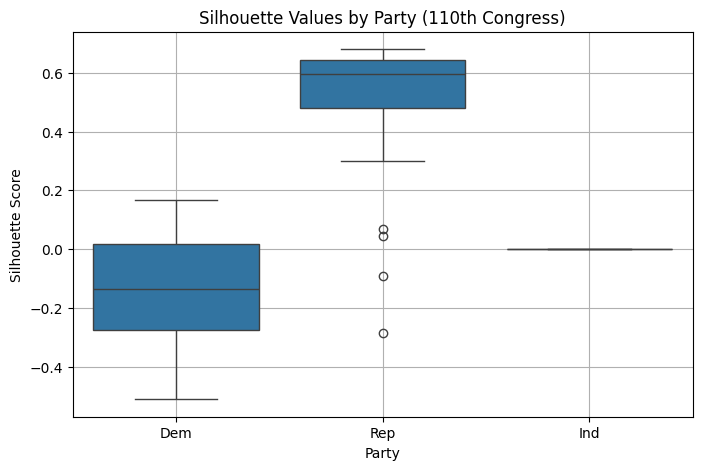

In [13]:
from sklearn.metrics import silhouette_samples
import seaborn as sns
import matplotlib.pyplot as plt

X110, y110 = session(110, senate, members)

D = cosine_distances(X110)

silhouette_vals = silhouette_samples(D, y110, metric='precomputed')

silhouette_df = pd.DataFrame({
    'Silhouette': silhouette_vals,
    'Party': y110.values
})

plt.figure(figsize=(8, 5))
sns.boxplot(data=silhouette_df, x='Party', y='Silhouette')
plt.title("Silhouette Values by Party (110th Congress)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


(Both distributions show one major party that is well-clustered and another that is not. Also, due to some long, asymmetric tails in the value distributions, we will prefer medians to means when scoring the silhouettes.)

# 5 (6.4)

Using agglomerative clustering with average linkage and 2 clusters, fit the voting records from the 95th Congress. Compute the adjusted Rand index with respect to the reference clustering implied by the party affiliations.

In [ ]:
ARI = None
agg = None  # should be of type AgglomerativeClustering

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score

X95, y95 = session(95, senate, members)

agg = AgglomerativeClustering(n_clusters=2, linkage='average')
cluster_labels = agg.fit_predict(X95)

ARI = adjusted_rand_score(y95, cluster_labels)

In [22]:
print(f"Adjusted Rand index for 95th session is {ARI:.4f}")

Adjusted Rand index for 95th session is 0.1985


In [23]:
# TESTS
assert str(type(agg)) == "<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>"
assert agg.linkage == "average"
assert 0.17 < ARI < 0.20
print("OK")

OK


# 6 (6.4)
Repeating the methodology of step 5, calculate the ARI for all sessions from the 91st through the 111th. Make a series of the results indexed by the session number.

In [ ]:
ARI2 = None
sessions = range(91, 112)
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score

sessions = list(range(91, 112))
ari_scores = {}

for session_num in sessions:
    X, y = session(session_num, senate, members)
    if len(np.unique(y)) < 2:
        continue
    agg = AgglomerativeClustering(n_clusters=2, linkage='average')
    labels = agg.fit_predict(X)
    ari_scores[session_num] = adjusted_rand_score(y, labels)

ARI2 = pd.Series(ari_scores)

In [25]:
print("Two-cluster ARIs:\n")
print(ARI2)

Two-cluster ARIs:

91     0.222675
92     0.174702
93     0.246721
94     0.145061
95     0.198545
96    -0.006088
97     0.978182
98     1.000000
99     0.882417
100    0.604561
101    0.960000
102    1.000000
103    0.920005
104    1.000000
105    1.000000
106    1.000000
107    1.000000
108    0.942166
109    0.904248
110    0.783747
111    0.932638
dtype: float64


(You should see a big step up, indicating an increase in the agreement between voting records and party affiliation underwent.)

In [26]:
# TESTS
assert type(ARI2) == pd.Series, "Result must be a series"
assert np.all(ARI2.index == sessions), "Must be indexed by session number"
assert np.all(ARI2.iloc[:6] < 0.3), "Early results are incorrect"
assert np.all(ARI2.iloc[-6:] > 0.75), "Late results are incorrect"
print("OK")

OK


# 7 (6.4)

Repeat step 6, but with the number of clusters equal to 3.

In [ ]:
ARI3 = None
sessions = range(91, 112)
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score

sessions = list(range(91, 112))
ari_scores_3 = {}

for session_num in sessions:
    X, y = session(session_num, senate, members)
    if len(np.unique(y)) < 2:
        continue  
    agg = AgglomerativeClustering(n_clusters=3, linkage='average')
    labels = agg.fit_predict(X)
    ari_scores_3[session_num] = adjusted_rand_score(y, labels)

ARI3 = pd.Series(ari_scores_3)

In [30]:
print("Three-cluster ARIs:\n")
print(ARI3)

Three-cluster ARIs:

91     0.207402
92     0.495647
93     0.394213
94     0.280774
95     0.173184
96     0.436031
97     0.960389
98     0.981859
99     0.865024
100    0.587557
101    0.981817
102    0.906018
103    0.966199
104    0.978946
105    0.883537
106    0.938117
107    0.925725
108    0.890902
109    0.921603
110    0.888571
111    0.898153
dtype: float64


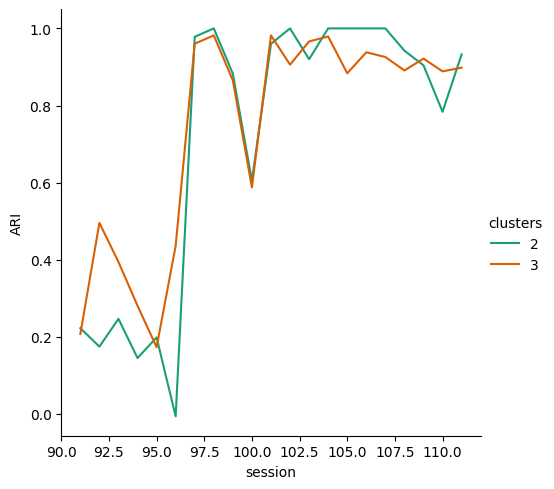

In [29]:
df = pd.concat((pd.DataFrame({"session": sessions, "clusters": 2, "ARI": ARI2}), pd.DataFrame({"session": sessions, "clusters": 3, "ARI": ARI3})))
sns.relplot(data=df, x="session", y="ARI", hue="clusters", kind="line", palette="Dark2");

In [28]:
# TESTS
assert type(ARI3) == pd.Series, "Result must be a series"
assert np.all(ARI3.index == sessions), "Must be indexed by session number"
assert np.all(ARI3.iloc[:6] < 0.5), "Early results are incorrect"
assert np.all(ARI3.iloc[-6:] > 0.8), "Late results are incorrect"
print("OK")

OK
